<a href="https://colab.research.google.com/github/sipocz/Zindi_plastic/blob/main/Zindi_Plastic_Cover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
import PIL
import pandas
from google.colab import drive

In [ ]:
_DEBUG_=False
_PROJECT_BASE_='/content/drive/MyDrive/Zindi_Plastic_images/'
_IMAGES_='images'
_TEST_IMAGES_='test_images'

_ORIG_='orig'


In [ ]:
ee.Authenticate()
ee.Initialize(project='zindiplasticproject')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def add_time(image):
  return image.addBands(image.getNumber('system:time_start'))

In [ ]:
def conditional(image):
  return ee.Algorithms.If(
      ee.Number(image.get('SUN_ELEVATION')).gt(40), image, ee.Image(0)
  )


In [ ]:
def gamma_correct(gamma, path):
    """

    Args:
      gamma: selected gamma value
      path: the path of the image

    Returns: gamma corrected image

    """
    im = PIL.Image.open(path)
    gamma1 = gamma
    row = im.size[0]
    col = im.size[1]
    result_img1 = PIL.Image.new(mode="RGB", size=(row, col), color=0)
    for x in range(row):
        for y in range(col):
            r = pow(im.getpixel((x, y))[0] / 255, (1 / gamma1)) * 255
            g = pow(im.getpixel((x, y))[1] / 255, (1 / gamma1)) * 255
            b = pow(im.getpixel((x, y))[2] / 255, (1 / gamma1)) * 255
            # add
            color = (int(r), int(g), int(b))
            result_img1.putpixel((x, y), color)
    #show
    return result_img1

In [ ]:
def image_download(index=int,longitude=float,latitude=float,place=str,sat=None,band=None,sdate="2024-04-15",edate="2024-04-17"):
    from math import gamma
    import geemap
    import ee

    # Google Earth Engine inicializálása
    ee.Initialize()

    if sat==None:
        sat='COPERNICUS/S2_HARMONIZED'
    if band==None:
        band=['B4','B3','B2']

    # 1000 méteres körzet létrehozása Budapest középpontjában
    point = ee.Geometry.Point([longitude, latitude])
    buffer = point.buffer(10).bounds()  # 1000 méteres buffer

    # Sentinel-2 műholdkép lekérése nappali időszakban
    collection = ee.ImageCollection(sat) \
        .filterBounds(buffer) \
        .filterDate(sdate, edate) \
        .sort('CLOUDY_PIXEL_PERCENTAGE')  # Legkevésbé felhős kép kiválasztása
    first_image = collection.first()  # Az első legkevésbé felhős kép

    # Ellenőrizd, hogy az első kép érvényes
    if first_image is None:
        raise ValueError("Nem találtunk érvényes képet a megadott időszakban.")

    # Kép RGB sávok kiválasztása
    image = first_image.select(band)  # Red, Green, Blue
    import matplotlib.pyplot as plt

    aoi=ee.Geometry.Rectangle(longitude-0.005,latitude-0.005,longitude+0.005,latitude+0.005 )


    rgb_img = geemap.ee_to_numpy(image,region=aoi)
    if _DEBUG_==True:
        print(rgb_img.shape)

    rgb_img_test = (255 * ((rgb_img[:, :, 0:3] ) / rgb_img[:,:,:].max())).astype("uint8")
    img=PIL.Image.fromarray(rgb_img_test)

    img=img.resize((192,192))
    return img


In [ ]:
pil_image=image_download(20,37.05635887,0.053674338,"Kenya",sat="COPERNICUS/S2_HARMONIZED",band=['B4','B3','B2'],sdate="2024-04-14",edate="2024-05-04")

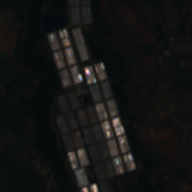

In [ ]:
pil_image

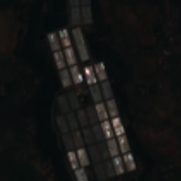

In [ ]:
pil_image.crop((0,0,181,181))


In [ ]:
image_download(20,37.05635887,0.053674338,"Kenya")

Exception: Image.select: Parameter 'input' is required.

In [ ]:

df_kenya=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Kenya_training.csv")


In [ ]:
df_kenya.head()

,ID,lon,lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,37.059054,0.046039,2731.0,3035.0,5418.0,5306.5,2958.0,4610.5,5099.5,2994.0,4108.5,3187.5,-6.861458,-12.162713,1
1,2,37.059503,0.047296,2921.0,3329.0,5834.0,6472.0,4144.5,5782.0,6302.0,3344.0,5269.0,4471.5,-8.082717,-14.619608,1
2,3,37.057527,0.047656,3828.0,4163.0,6420.0,7890.5,5408.5,6695.5,7302.0,4380.0,6905.0,6905.5,-7.767043,-14.880353,1
3,4,37.057976,0.047925,2556.0,2839.0,4822.0,5276.5,3201.0,4643.0,5069.5,2787.0,3832.0,2867.5,-7.773118,-15.587653,1
4,5,37.056359,0.048554,3790.0,4009.0,6476.0,6199.5,4285.0,5711.0,6079.5,3939.0,4892.5,3702.5,-6.104467,-15.431915,1


In [ ]:
def image_generation(df,image_id):
    for i,row in df.iterrows():
        image=image_download(row.ID,row.lon,row.lat,image_id,sat=_sat_,band=_band_,sdate="2024-04-14",edate="2024-05-04")
        image.save(_PROJECT_BASE_+_IMAGES_+"/"+str(int(row.ID))+'_'+str(int(row.TARGET))+"_"+image_id+".jpg")
        print(str(i).rjust(3,'0'),end=".")
        if i % 20==0:
            print("*")

In [ ]:
_sat_=None
_band_=None
_image_id_="kenya"

In [ ]:
image_generation(df_kenya,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [ ]:
df_spain=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Spain_training.csv")
_image_id_="spain"

In [ ]:
image_generation(df_spain,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [ ]:
df_vnm=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/VNM_training.csv")
_image_id_="vnm"

In [ ]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1


In [ ]:
df_vnm['lon']=df_vnm["Lon"]
df_vnm['lat']=df_vnm["Lat"]

In [ ]:
image_generation(df_vnm,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

701.702.703.704.705.706.707.708.709.710.711.712.713.714.715.716.717.718.719.720.*
721.722.723.724.725.726.727.728.729.730.731.732.733.734.735.736.737.738.739.740.*
741.742.743.744.745.746.747.748.749.750.751.752.753.754.755.756.757.758.759.760.*
761.762.763.764.765.766.767.768.769.770.771.772.773.774.775.776.777.778.779.780.*
781.782.783.784.785.786.787.788.789.790.791.792.793.794.

795.796.797.798.799.800.*
801.802.803.804.805.806.807.808.809.810.811.812.813.814.815.816.817.818.819.820.*
821.822.823.824.825.826.827.828.829.830.831.832.833.834.835.836.837.838.839.840.*
841.842.843.844.845.846.847.848.849.850.851.852.853.854.855.856.857.858.859.860.*
861.862.863.864.865.866.867.868.869.870.871.872.873.874.875.876.877.878.879.880.*
881.882.883.884.885.886.887.888.889.890.891.892.893.894.895.896.897.898.899.900.*
901.902.903.904.905.906.907.908.909.910.911.912.913.914.915.916.917.918.919.920.*
921.922.923.924.925.926.927.928.929.930.931.932.933.934.935.936.937.938.939.940.*
941.942.943.944.945.946.947.948.949.950.951.952.953.954.955.956.957.958.959.960.*
961.962.963.964.965.966.967.968.

In [ ]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1,108.307403,11.706890
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1,108.363279,11.778036
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1,108.193946,11.689462
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1,108.200324,11.691618
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1,108.203109,11.694313


In [ ]:
df_spain_test=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Spain_validation.csv")
_image_id_="_spain_testing"
_sat_=None
_band_=None
df_spain_test["TARGET"]=0

In [ ]:
image_generation(df_spain_test,_image_id_)


000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [ ]:
df_vnm_test=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/VNM_testing.csv")
_image_id_="_vnm_testing"
_sat_=None
_band_=None
df_vnm_test["TARGET"]=0
df_vnm_test["lon"]=df_vnm_test["Lon"]
df_vnm_test["lat"]=df_vnm_test["Lat"]

In [ ]:
df_vnm_test.head()


,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.406667,11.699973,2284.0,2429.0,2857.0,3314.5,2690.5,3043.5,3165.0,2461.0,3385.5,2848.0,-9.688691,-17.492636,0,108.406667,11.699973
1,2,108.364087,11.780641,2606.0,2743.0,3708.0,4164.0,3226.5,3826.5,4080.5,2819.0,3978.5,3402.0,-8.679594,-16.148212,0,108.364087,11.780641
2,3,108.201133,11.690091,1965.0,2174.0,3713.0,3767.0,2475.5,3473.5,3750.5,2050.0,2870.5,2309.0,-7.793950,-14.815912,0,108.201133,11.690091
3,4,108.196731,11.692157,2010.0,2051.0,2401.0,2510.0,2234.0,2448.0,2532.0,2106.0,2476.5,2137.0,-9.485932,-15.773308,0,108.196731,11.692157
4,5,108.197809,11.695032,2084.0,2253.0,3148.0,3371.0,2628.0,3212.5,3369.0,2301.0,3226.0,2874.0,-7.751073,-16.848070,0,108.197809,11.695032


In [ ]:
image_generation(df_vnm_test,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [ ]:
df_kenya_test=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Kenya_testing.csv")
_image_id_="_kenya_testing"
_sat_=None
_band_=None
df_kenya_test["TARGET"]=0


In [ ]:
image_generation(df_kenya_test,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [ ]:

# _sat_="LANDSAT/LC08/C02/T1_L2"
# _band_=['SR_B7','SR_B3','SR_B2']
# _image_id_="_kenya_landsat"

In [ ]:
# image_generation(df_kenya,_image_id_)

In [ ]:
def format_image(image_dir):
    image = tf.read_file(image_dir)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_image_with_pad(image, 256, 256, align_corners=True)
    return image

In [ ]:
test_images_dir=_PROJECT_BASE_+_TEST_IMAGES_
images_dir=_PROJECT_BASE_+_IMAGES_

In [ ]:
!mv {images_dir+'/*_1_*.jpg'} {images_dir+'/plastic'}
!mv {images_dir+'/*_2_*.jpg'} {images_dir+'/non_plastic'}

In [ ]:
!mv {images_dir+'/*_0_*.jpg'} {test_images_dir}

In [ ]:
# END of Image generation

In [ ]:
stop here the map download

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir local
!mkdir images

In [3]:
_PROJECT_BASE_='/content/drive/MyDrive/Zindi_Plastic_images/'
_IMAGES_='images'

In [4]:
!cp -r {_PROJECT_BASE_+_IMAGES_} ./local

In [5]:
#!rm {_PROJECT_BASE_+_IMAGES_+'/*.jpg'}

In [6]:

import pandas as pd

In [7]:
!rm /content/local/images/plastic/*__*.jpg

rm: cannot remove '/content/local/images/plastic/*__*.jpg': No such file or directory


In [8]:
_DEBUG_=False
_PROJECT_BASE_='./local/'
_IMAGES_='images'
_TEST_IMAGES_='test_images'

_ORIG_='orig'


In [9]:
train_path=_PROJECT_BASE_+_IMAGES_


test_path=_PROJECT_BASE_+_IMAGES_
valid_path=_PROJECT_BASE_+_IMAGES_

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# extract images to training set by applying data preprocessing and data augmentation
random_seed = 26
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2,).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['plastic', 'non_plastic'], batch_size=1, subset='training',seed=random_seed)


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['plastic', 'non_plastic'], batch_size=1, subset='validation',seed=random_seed)



Found 2261 images belonging to 2 classes.
Found 564 images belonging to 2 classes.


In [12]:
import matplotlib.pyplot as plt
def plot_imgs(item_dir, top=100):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(2, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')



['non_plastic', 'plastic']


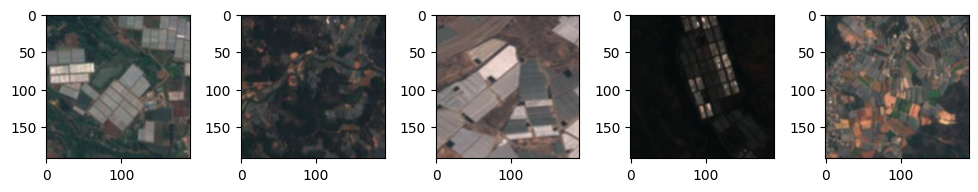

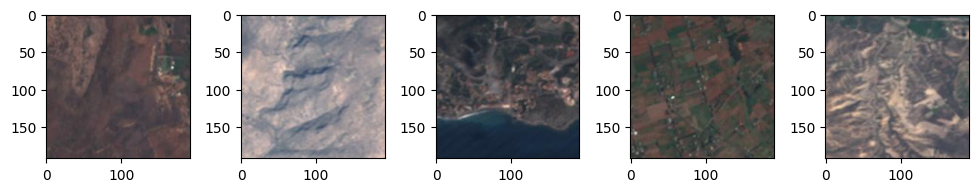

In [13]:
import os
print(os.listdir(train_path))

data_path = train_path

plot_imgs(data_path+'/plastic')

plot_imgs(data_path+'/non_plastic')


In [14]:
batch_size = 32
random_seed = 32 #26

x_pxm=224
y_pxm=224
divider=1
bpc=3
images_path=_PROJECT_BASE_+_IMAGES_

# Data Generator
train=ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.0,zoom_range = 0.0,
                         width_shift_range = 0.0,
                         height_shift_range = 0.0,)

test=ImageDataGenerator(rescale=1./255,validation_split=0.1)


x_px=int(x_pxm/divider)
y_px=int(y_pxm/divider)

print(f"X: {x_px}, Y: {y_px}")
train_generator=train.flow_from_directory(images_path,target_size=(x_px,y_px),batch_size=batch_size,class_mode='binary',
                                          subset='training',
                                          color_mode="rgb",
                                          seed=random_seed,
                                          shuffle=True)
test_generator=test.flow_from_directory(images_path,target_size=(x_px,y_px),batch_size=batch_size,class_mode='binary',
                                        subset='validation',
                                        color_mode="rgb",
                                        seed=random_seed,
                                        shuffle=True)



print(train_generator.class_mode)

X: 224, Y: 224
Found 2543 images belonging to 2 classes.
Found 282 images belonging to 2 classes.
binary


In [15]:

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'non_plastic', 1: 'plastic'}


In [16]:
from tensorflow.keras.layers import Input,Dense,Embedding,LSTM,TimeDistributed, Flatten, Bidirectional, Conv2D,Conv3D, Dropout,Convolution2D, Conv2DTranspose, Input
from tensorflow.keras.layers import MaxPool2D, Rescaling,RandomFlip,RandomRotation, Reshape,BatchNormalization,AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta,Adam,SGD,Adamax
from tensorflow.keras.losses import sparse_categorical_crossentropy,categorical_crossentropy, MeanSquaredError
from tensorflow.keras import backend as K
from keras.regularizers import l1
from keras.initializers import RandomNormal,Zeros,GlorotUniform

K.clear_session()



In [17]:
inputs= Input(shape=(224,224,3))


e = Conv2D(32, (3, 3), activation='relu',padding='same',)(inputs)
e=BatchNormalization()(e)
o1 = Conv2D(32, (3, 3), activation='relu',padding='same',)(e)


e = AveragePooling2D((2, 2),strides=(2, 2))(o1)
mp= MaxPool2D((2, 2),strides=(2, 2))(o1)
#e = Dropout(0.01)(e)

e = Conv2D(64, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = Conv2D(64, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = AveragePooling2D((2, 2),strides=(2, 2))(e)

mp = Conv2D(64, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp = Conv2D(64, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp= MaxPool2D((2, 2),strides=(2, 2))(mp)

#e = Dropout(0.01)(e)

e = Conv2D(64, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = Conv2D(64, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = Conv2D(64, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)

e = AveragePooling2D((2, 2), strides=(2, 2))(e)

mp = Conv2D(64, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp = Conv2D(64, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp = Conv2D(64, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)

mp = MaxPool2D((2, 2), strides=(2, 2))(mp)




#e = Dropout(0.01)(e)

e = Conv2D(128, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)

e = AveragePooling2D((2, 2), strides=(2,2))(e)


mp = Conv2D(128, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp = Conv2D(128, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp = Conv2D(128, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)

mp = MaxPool2D((2, 2), strides=(2, 2))(mp)



#e = Dropout(0.1)(e)

e = Conv2D(128, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same',)(e)
e=BatchNormalization()(e)

e = AveragePooling2D((2, 2), strides=(2,2))(e)

mp = Conv2D(128, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp = Conv2D(128, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)
mp = Conv2D(128, (3, 3), activation='relu',padding='same',)(mp)
mp=BatchNormalization()(mp)

mp = MaxPool2D((2, 2), strides=(2, 2))(mp)



#e = Dropout(0.1)(e)
m= Flatten()(mp)
l = Flatten()(e)


m = Dense(800, activation='sigmoid', )(m)
m = Dropout(0.1)(m)
m = Dense(200, activation='sigmoid',)(m)

m = Dense(20, activation='sigmoid', )(m)

l = Dense(800, activation='sigmoid', )(l)
l = Dropout(0.1)(l)
l = Dense(200, activation='sigmoid', )(l)
l = Dense(20, activation='sigmoid', )(l)



o= Concatenate()([m,l])

decoded = Dense(1, activation='sigmoid')(o)


zindi_plastic_model = Model(inputs, decoded)




In [18]:

from keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='Model_-{val_loss:.4f}-{loss:.4f}.keras',
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [19]:

paths=data_path
XSize=224
YSize=224




from keras.models import load_model

# load model if you have one
#model=load_model(modelfname)

def lr_scheduler(epoch, lr):
  # not used currently
  # defined for later usage
  return 0.01

LR_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)


#cce = tf.keras.losses.SparseCategoricalCrossentropy()

bce=tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.SparseCategoricalAccuracy()


zindi_plastic_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 112, 112, 32)   │              0 │ conv2d_1[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1  

 Total params: 12,340,225 (47.07 MB)

 Trainable params: 12,335,809 (47.06 MB)

 Non-trainable params: 4,416 (17.25 KB)

In [20]:
!rm *.keras

rm: cannot remove '*.keras': No such file or directory


In [27]:
model_name="Model_-0.1544-0.0593.keras"
#282/282 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - binary_accuracy: 0.9695 - loss: 0.0893 - val_binary_accuracy: 0.9645 - val_loss: 0.1057

In [28]:
model_mounted_path="./"

In [29]:
#start from here if you have a trained model
_LOAD_MODEL_=True

if _LOAD_MODEL_:
    from tensorflow.keras.models import load_model


    zindi_plastic_model = load_model(model_mounted_path+model_name) # Load the best model

In [ ]:

# Train Model
from IPython.display import clear_output



for i in range(3,4):
    ratex={0:0.0001,1:0.00005, 2:0.00001,3:0.000005}  #ratex={0:0.000008,1:0.0000001} ez a jó az elején
    epocsd={0:5,1:12,2:50, 3:50}
    batchsd={0:32,1:32,2:32,3:32}
    #clear_output(wait=True)
    print("-"*35)
    print(f"num:{i:4}, Learning Rate:{ratex[i]:9} epocs:{epocsd[i]:6}")
    print("-"*35)

    optimizer=Adam(ratex[i])

    #zindi_plastic_model.summary()
    zindi_plastic_model.compile(loss=bce, optimizer=optimizer, metrics=["binary_accuracy"])


    history = zindi_plastic_model.fit(train_generator, epochs=epocsd[i],
                              validation_data=test_generator,
                              batch_size=batchsd[i],
                              callbacks=[model_checkpoint_callback],)


-----------------------------------
num:   3, Learning Rate:    5e-06 epocs:    50
-----------------------------------
Epoch 1/50
35/80 ━━━━━━━━━━━━━━━━━━━━ 17:41 24s/step - binary_accuracy: 0.9807 - loss: 0.0618

In [ ]:
for i in range(1,2):
    ratex={0:0.000001, 1:0.0000003,2:0.000001}  #ratex={0:0.000008,1:0.0000001} ez a jó az elején
    epocsd={0:12,1:12}
    batchsd={0:16,1:16}
    #clear_output(wait=True)
    print("-"*35)
    print(f"num:{i:4}, Learning Rate:{ratex[i]:9} epocs:{epocsd[i]:6}")
    print("-"*35)

    optimizer=Adam(ratex[i])

    #zindi_plastic_model.summary()
    zindi_plastic_model.compile(loss=bce, optimizer=optimizer, metrics=["binary_accuracy"])


    history = zindi_plastic_model.fit(train_generator, epochs=epocsd[i],
                              validation_data=test_generator,
                              batch_size=batchsd[i],
                              callbacks=[model_checkpoint_callback],)

In [ ]:
 # if you need more trainig...
 history = zindi_plastic_model.fit(train_generator, epochs=epocsd[i],
                              validation_data=test_generator,
                              batch_size=batchsd[i],
                              callbacks=[model_checkpoint_callback])

In [ ]:
#save the models to the google drive
model_path="/content/drive/MyDrive/zindi_plastic/models"
!cp *.keras {model_path}

In [ ]:
Model Usage

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
_DEBUG_=False
_PROJECT_BASE_='/content/drive/MyDrive/zindi_plastic/'
_IMAGES_='images'
_TEST_IMAGES_='test_images/'
_MODELS_='models/'

_ORIG_='orig'

In [ ]:
test_images_dir=_PROJECT_BASE_+_TEST_IMAGES_
images_dir=_PROJECT_BASE_+_IMAGES_

In [ ]:
model_path=_PROJECT_BASE_+_MODELS_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir local

In [ ]:
!mkdir local/test_images/
!mkdir local/models

In [ ]:
model_name="Model_-0.2324-0.1540.keras"

In [ ]:
!cp {_PROJECT_BASE_+_MODELS_+model_name} ./local/models

In [ ]:
!cp {_PROJECT_BASE_+_TEST_IMAGES_+'*.jpg'} ./local/test_images

In [ ]:
from tensorflow.keras.models import load_model


model = load_model("./"+model_name) # Load the best model

In [ ]:
def format_image(image_dir,show_image=True):
    image = tf.io.read_file(image_dir)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image /= 255.0  # Skálázás 0 és 1 közé
    image = tf.image.resize_with_pad(image, 224, 224)
    #image = tf.keras.applications.vgg16.preprocess_input(image)
    if show_image:
        plt.imshow(image)
        plt.show()
    return image

In [ ]:
import numpy as np
def predict_image(image_path, show_image=True):
    image = format_image(image_path,show_image)
    image = np.expand_dims(image, axis=0) # A modell bemenete egy batch, ezért kell a dimenzió bővítése
    prediction = model.predict(image)
    model_out=prediction
    #print(model_out)

    if model_out[0][0]<0.5:
        prediction=0
        #print("Non Plastic")
    else:
        prediction=1
        #print("Plastic" )
    return prediction

In [ ]:
file_name=_PROJECT_BASE_+"images/plastic/150_1__kenya.jpg"

In [ ]:
#model_out=predict_image(file_name)

In [ ]:
def fname_converter(fname):
    country_name={"kenya":"Kenya","spain":"Spain","vnm":"VNM"}
    o1=fname.split('/')[-1].split("_")
    index=o1[0]
    country=o1[-2]
    return(country_name[country]+"_"+index)


In [ ]:
def predict_directory(directory,show_image=False):
    #directory="./local/images/plastic/"
    jpg_list=[directory+f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    null_counter=0
    non_null_counter=0
    out_list=[]
    for jpg_list_element in jpg_list:
        prediction=predict_image(jpg_list_element,show_image)

        if prediction==0:
            null_counter+=1
        else:
            non_null_counter+=1

        print(f"Null: {null_counter}, Non Null: {non_null_counter}")
        out_list.append((jpg_list_element,prediction,fname_converter(jpg_list_element)))
    return out_list


In [ ]:
predicted_list=predict_directory(test_images_dir,show_image=False)

In [ ]:
predicted_list

In [ ]:
import pandas as pd

In [ ]:
submission_path=_PROJECT_BASE_+"orig/SampleSubmission.csv"
test_df=pd.read_csv(submission_path)
predicted_dict={predicted_list_element[-1]:predicted_list_element[-2] for predicted_list_element in predicted_list}

In [ ]:
test_df.set_index("ID", inplace=True)

In [ ]:
for key in predicted_dict:
    test_df.loc[key,"TARGET"]=predicted_dict[key] if predicted_dict[key]==1 else 2
#test_df.loc["Kenya_1","TARGET"]=1

In [ ]:
test_df.head()

In [ ]:
test_df["TARGET"]=test_df["TARGET"].astype(int)


In [ ]:
test_df.to_csv("submission09.csv",index=True)